# Python API Client Walkthrough

_Last Updated: Version `2024.08.20`_

This notebook demonstrates basic functionality offered by the Coin Metrics Python API Client using Coin Metrics Community Data.

Coin Metrics offers a vast assortment of data for hundreds of cryptoassets. The Python API Client allows for easy access to this data using Python without needing to create your own wrappers using `requests` and other such libraries.

## Prerequisites

First, Python must be installed. Download and install from [python.org](https://www.python.org/downloads/). The Coin Metrics API Client is best used with Python 3.8 or later.

Then, install the Python API Client:

`pip install coinmetrics-api-client`

Some of the optional libraries such as pandas, numpy, and seaborn are used in the notebook to make the examples more interactive. These libraries are not required to use the Coin Metrics API Client.

You are now ready to run the code in the rest of the notebook.

## Resources

To understand the data that Coin Metrics offers, feel free to peruse the resources below.

* The [Coin Metrics API v4](https://docs.coinmetrics.io/api/v4) website contains the full set of endpoints and data offered by Coin Metrics.
* The [Coin Metrics Product Documentation](https://docs.coinmetrics.io/) gives detailed, conceptual explanations of the data that Coin Metrics offers.
* The [API Spec](https://coinmetrics.github.io/api-client-python/site/api\_client.html) contains a full list of functions.
* The [Coverage Tool](https://coverage.coinmetrics.io/) shows what assets, metrics, and other data types are covered.

## Setup

In [1]:
from os import environ
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import logging
from datetime import date, datetime, timedelta
from coinmetrics.api_client import CoinMetricsClient

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [3]:
# We recommend privately storing your API key in your local environment.
# Uncomment below if you have an API Key. Otherwise we will use Community data.
# try:
#     api_key = environ["CM_API_KEY"]
#     logging.info("Using API key found in environment")
# except KeyError:
#     api_key = ""
#     logging.info("API key not found. Using community client")

client = CoinMetricsClient()
# client = CoinMetricsClient(api_key)

In [4]:
assets = ['btc', 'eth']
metrics = ['ReferenceRateUSD', 'CapMrktEstUSD']
start_time = datetime(year=2024, month=9, day=1)
end_time = datetime(year=2024, month=9, day=30)
asset_mapping = {i: assets[i] for i in range(len(assets))}

```
{0: 'btc', 1: 'eth'}
```

## Catalogs

The Coin Metrics API contains two types of catalog endpoints (Python client functions in paranthesis): the `catalog` (`catalog_*_v2`) and `catalog-all` (`catalog_full_*_v2`).

The `catalog` endpoint displays the set of data available to your API key. The `catalog-all` endpoint displays the full set of data for our dataset.

In [5]:
asset_metrics_catalog = client.catalog_asset_metrics_v2(assets=assets).to_list()
full_asset_metrics_catalog = client.catalog_full_asset_metrics_v2(assets=assets).to_list()

Catalog objects return a list of dictionaries. For `catalog_asset_metrics_v2`, each element of the list is an asset, while each dictionary is a set of metadata for that specific asset.

In [6]:
print(f"Asset Metrics Catalog metadata includes: {list(asset_metrics_catalog[0].keys())}")

for i in asset_mapping:
    print(f"Asset {asset_mapping[i]} has {len(asset_metrics_catalog[i]['metrics'])} metrics in catalog.")
    print(f"Asset {asset_mapping[i]} has {len(full_asset_metrics_catalog[i]['metrics'])} metrics in catalog-all.")

Asset Metrics Catalog metadata includes: ['asset', 'metrics']
Asset btc has 147 metrics in catalog.
Asset btc has 696 metrics in catalog-all.
Asset eth has 146 metrics in catalog.
Asset eth has 699 metrics in catalog-all.


```
Asset Metrics Catalog metadata includes: ['asset', 'metrics']
Asset btc has 147 metrics in catalog.
Asset btc has 513 metrics in catalog-all.
Asset eth has 146 metrics in catalog.
Asset eth has 500 metrics in catalog-all.
```

For more details on what metrics are covered, see [Coverage](https://coverage.coinmetrics.io/asset-metrics-v2)

## Getting Timeseries Data

Next, we will pull timeseries data. Typically there are two types of timeseries data that you can pull: raw observations such as trades and aggregated metrics. We will explore these two below.

### Asset Metrics

First, we will use the [`asset-metrics`](https://docs.coinmetrics.io/api/v4/#tag/Timeseries/operation/getTimeseriesAssetMetrics) endpoint to get metrics for BTC and ETH.

In [7]:
btc_metrics = [m['metric'] for m in asset_metrics_catalog[0]['metrics']]
eth_metrics = [m['metric'] for m in asset_metrics_catalog[1]['metrics']]

You can bound your query by time like below:

In [8]:
df_asset_metrics = client.get_asset_metrics(
    assets=assets, 
    metrics=metrics, 
    start_time=start_time,
    end_time=end_time
).to_dataframe()

In [9]:
df_asset_metrics.head()

,asset,time,CapMrktEstUSD,ReferenceRateUSD
0,btc,2024-09-01 00:00:00+00:00,1132518348250.186279,58959.926273
1,btc,2024-09-02 00:00:00+00:00,1168286956855.852539,57349.080718
2,btc,2024-09-03 00:00:00+00:00,1138274882375.744873,59159.023888
3,btc,2024-09-04 00:00:00+00:00,1146114653782.878418,57637.775444
4,btc,2024-09-05 00:00:00+00:00,1108213762229.152832,58033.39897


|   | asset | time                      | CapMrktEstUSD        | ReferenceRateUSD |
| - | ----- | ------------------------- | -------------------- | ---------------- |
| 0 | btc   | 2024-08-15 00:00:00+00:00 | 1137894996787.05249  | 58840.64668      |
| 1 | btc   | 2024-08-16 00:00:00+00:00 | 1163252605521.227783 | 57644.187688     |
| 2 | btc   | 2024-08-17 00:00:00+00:00 | 1172900035803.550781 | 58927.276509     |
| 3 | btc   | 2024-08-18 00:00:00+00:00 | 1160659435495.434814 | 59414.674335     |
| 4 | btc   | 2024-08-19 00:00:00+00:00 | 1172894781992.733887 | 58793.206146     |

<Axes: xlabel='time'>

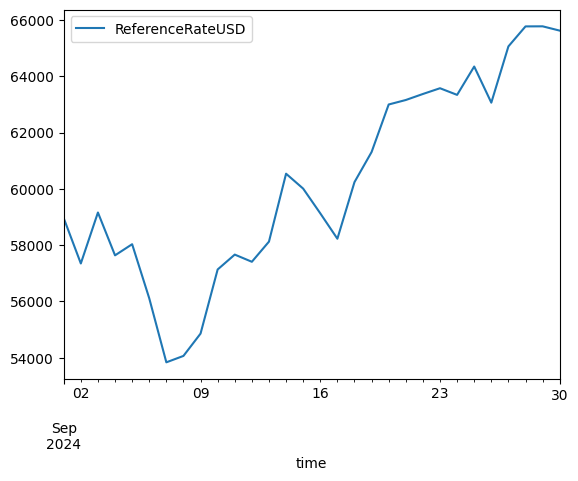

In [10]:
df_asset_metrics.loc[df_asset_metrics.asset=='btc'].plot(x='time', y='ReferenceRateUSD')

<figure><img src="../../.gitbook/assets/walkthrough_community_price.png" alt=""><figcaption></figcaption></figure>


Coin Metrics supports several metrics for various data types such as exchanges, markets, and asset-pairs.

You can also bound your queries by using the `limit` parameter.

In [11]:
df_asset_metrics_limit = client.get_asset_metrics(
    assets=assets, 
    metrics=btc_metrics[:5], 
    start_time=start_time,
    end_time=end_time,
    limit_per_asset=2
).to_dataframe()

In [12]:
df_asset_metrics_limit

,asset,time,AdrActCnt,AdrBal1in100KCnt,AdrBal1in100MCnt,AdrBal1in10BCnt,AdrBal1in10KCnt
0,btc,2024-09-01 00:00:00+00:00,660770,9283,3046587,20365534,973
1,btc,2024-09-02 00:00:00+00:00,717673,9284,3046904,20359814,972
2,eth,2024-09-01 00:00:00+00:00,548611,6907,1836310,27996184,1221
3,eth,2024-09-02 00:00:00+00:00,488354,6902,1836617,28008369,1218


|   | asset | time                      | AdrActCnt | AdrBal1in100KCnt | AdrBal1in100MCnt | AdrBal1in10BCnt | AdrBal1in10KCnt |
| - | ----- | ------------------------- | --------- | ---------------- | ---------------- | --------------- | --------------- |
| 0 | btc   | 2024-08-15 00:00:00+00:00 | 715632    | 9229             | 3054724          | 20292616        | 973             |
| 1 | btc   | 2024-08-16 00:00:00+00:00 | 700335    | 9231             | 3055010          | 20300505        | 977             |
| 2 | eth   | 2024-08-15 00:00:00+00:00 | 603353    | 6862             | 1837926          | 27972812        | 1226            |
| 3 | eth   | 2024-08-16 00:00:00+00:00 | 541263    | 6871             | 1837366          | 27962507        | 1223            |

### Market Observations

The other common timeseries data type that you will encounter are individual observations.

First, we will need to familiarize ourselves with the market convention which we can find on [faqs](../../market-data/faqs/ "mention"). You can see a full list of markets by using the `reference-data` endpoint.

In [13]:
df_coinbase_btc_markets = client.reference_data_markets(asset='btc', exchange='coinbase').to_dataframe()

In [14]:
df_coinbase_btc_markets.head()

,market,exchange,base,quote,pair,symbol,type,size_asset,margin_asset,strike,...,order_price_increment,order_price_min,order_price_max,order_size_min,order_taker_fee,order_maker_fee,margin_trading_enabled,experimental,base_native,quote_native
0,coinbase-1inch-btc-spot,coinbase,1inch,btc,1inch-btc,1INCH-BTC,spot,<NA>,<NA>,<NA>,...,0.0,0.0,<NA>,0.000016,<NA>,<NA>,False,<NA>,<NA>,<NA>
1,coinbase-aave-btc-spot,coinbase,aave,btc,aave-btc,AAVE-BTC,spot,<NA>,<NA>,<NA>,...,0.000001,0.000001,<NA>,0.000016,<NA>,<NA>,False,<NA>,<NA>,<NA>
2,coinbase-ada-btc-spot,coinbase,ada,btc,ada-btc,ADA-BTC,spot,<NA>,<NA>,<NA>,...,0.0,0.0,<NA>,0.000016,<NA>,<NA>,False,<NA>,<NA>,<NA>
3,coinbase-algo-btc-spot,coinbase,algo,btc,algo-btc,ALGO-BTC,spot,<NA>,<NA>,<NA>,...,0.0,0.0,<NA>,0.000016,<NA>,<NA>,False,<NA>,<NA>,<NA>
4,coinbase-ankr-btc-spot,coinbase,ankr,btc,ankr-btc,ANKR-BTC,spot,<NA>,<NA>,<NA>,...,0.0,0.0,<NA>,0.000016,<NA>,<NA>,False,<NA>,<NA>,<NA>


|   | market                  | exchange | base  | quote | pair      | symbol    | type | size\_asset | margin\_asset | strike | ... | order\_amount\_min | order\_amount\_max | order\_price\_increment | order\_price\_min | order\_price\_max | order\_size\_min | order\_taker\_fee | order\_maker\_fee | margin\_trading\_enabled | experimental |
| - | ----------------------- | -------- | ----- | ----- | --------- | --------- | ---- | ----------- | ------------- | ------ | --- | ------------------ | ------------------ | ----------------------- | ----------------- | ----------------- | ---------------- | ----------------- | ----------------- | ------------------------ | ------------ |
| 0 | coinbase-1inch-btc-spot | coinbase | 1inch | btc   | 1inch-btc | 1INCH-BTC | spot | \<NA>       | \<NA>         | \<NA>  | ... | \<NA>              | \<NA>              | 0.0                     | 0.0               | \<NA>             | 0.000016         | \<NA>             | \<NA>             | False                    | \<NA>        |
| 1 | coinbase-aave-btc-spot  | coinbase | aave  | btc   | aave-btc  | AAVE-BTC  | spot | \<NA>       | \<NA>         | \<NA>  | ... | \<NA>              | \<NA>              | 0.000001                | 0.000001          | \<NA>             | 0.000016         | \<NA>             | \<NA>             | False                    | \<NA>        |
| 2 | coinbase-ada-btc-spot   | coinbase | ada   | btc   | ada-btc   | ADA-BTC   | spot | \<NA>       | \<NA>         | \<NA>  | ... | \<NA>              | \<NA>              | 0.0                     | 0.0               | \<NA>             | 0.000016         | \<NA>             | \<NA>             | False                    | \<NA>        |
| 3 | coinbase-algo-btc-spot  | coinbase | algo  | btc   | algo-btc  | ALGO-BTC  | spot | \<NA>       | \<NA>         | \<NA>  | ... | \<NA>              | \<NA>              | 0.0                     | 0.0               | \<NA>             | 0.000016         | \<NA>             | \<NA>             | False                    | \<NA>        |
| 4 | coinbase-ankr-btc-spot  | coinbase | ankr  | btc   | ankr-btc  | ANKR-BTC  | spot | \<NA>       | \<NA>         | \<NA>  | ... | \<NA>              | \<NA>              | 0.0                     | 0.0               | \<NA>             | 0.000016         | \<NA>             | \<NA>             | False                    | \<NA>        |

5 rows × 37 columns

We can then pass these markets onto the `timeseries/market-*` endpoints. Below is an example of how to pull individual market trades.

In [15]:
df_coinbase_btc_trades = client.get_market_trades(
    markets=["coinbase-btc-usd-spot"],
    start_time=datetime.now()-timedelta(seconds=60),
    end_time=datetime.now(),
).to_dataframe()

In [16]:
df_coinbase_btc_trades.head()

,market,time,coin_metrics_id,amount,price,database_time,side
0,coinbase-btc-usd-spot,2024-10-25 15:22:44.919441+00:00,705966854,0.000004,68353.27,2024-10-25 15:22:45.721609+00:00,buy
1,coinbase-btc-usd-spot,2024-10-25 15:22:44.919441+00:00,705966855,0.000012,68353.27,2024-10-25 15:22:45.721609+00:00,buy
2,coinbase-btc-usd-spot,2024-10-25 15:22:44.919441+00:00,705966856,0.002187,68354.37,2024-10-25 15:22:45.721609+00:00,buy
3,coinbase-btc-usd-spot,2024-10-25 15:22:44.919441+00:00,705966857,0.002523,68354.38,2024-10-25 15:22:45.721609+00:00,buy
4,coinbase-btc-usd-spot,2024-10-25 15:22:45.078614+00:00,705966858,0.001043,68353.27,2024-10-25 15:22:45.721609+00:00,buy


|   | market                | time                             | coin\_metrics\_id | amount   | price    | database\_time                   | side |
| - | --------------------- | -------------------------------- | ----------------- | -------- | -------- | -------------------------------- | ---- |
| 0 | coinbase-btc-usd-spot | 2024-09-13 16:55:02.663733+00:00 | 691698441         | 0.008    | 59491.6  | 2024-09-13 16:55:03.253369+00:00 | sell |
| 1 | coinbase-btc-usd-spot | 2024-09-13 16:55:02.670644+00:00 | 691698442         | 0.008    | 59491.61 | 2024-09-13 16:55:03.253369+00:00 | buy  |
| 2 | coinbase-btc-usd-spot | 2024-09-13 16:55:03.057923+00:00 | 691698443         | 0.001186 | 59491.61 | 2024-09-13 16:55:03.771512+00:00 | buy  |
| 3 | coinbase-btc-usd-spot | 2024-09-13 16:55:03.143752+00:00 | 691698444         | 0.15742  | 59491.6  | 2024-09-13 16:55:03.771512+00:00 | sell |
| 4 | coinbase-btc-usd-spot | 2024-09-13 16:55:03.143816+00:00 | 691698445         | 0.076281 | 59491.6  | 2024-09-13 16:55:03.771512+00:00 | sell |

### Examples from State of the Network

The Python API Client is often used for transforming data for [State of the Network](https://coinmetrics.substack.com/). Below are some examples of data transformations done to produce the data visualizations.

#### Example 1: Get returns by coin in the CM reference rates universe over the last 10-years

In [State of the Network #128](https://coinmetrics.substack.com/p/coin-metrics-state-of-the-network-53b), we looked at the returns for each asset dating back the last 10 years.

![returns-10-yr](https://cdn.substack.com/image/fetch/f\_auto,q\_auto:good,fl\_progressive:steep/https%3A%2F%2Fbucketeer-e05bbc84-baa3-437e-9518-adb32be77984.s3.amazonaws.com%2Fpublic%2Fimages%2F38b38adb-c4b7-43f6-a387-0cbae028861a\_985x525.png)

We can generate this data by weaving in the `catalog_asset_metrics_v2` and `get_asset_metrics` endpoint. The code snippets below demonstrate how to do this with a small list of assets.

In [17]:

# Get all assets that have a reference rate 
assets_refrate = client.catalog_asset_metrics_v2(metrics="ReferenceRateUSD")
# Get list of assets with daily ref rate 
# uncomment the top line to look at *every* asset with reference rates
# asset_with_ref_rates = assets_refrate[0]["frequencies"][0]["assets"]
asset_with_ref_rates = ['btc', 'eth', 'bnb', 'ada', 'doge', 'xrp']
#Query API for prices, daily CM reference rates as dataframe
metrics = "ReferenceRateUSD"
frequency = "1d"

logging.info("Getting prices...")
df_prices = client.get_asset_metrics(
    assets=asset_with_ref_rates,
    metrics=metrics,
    frequency=frequency,
    start_time=start_time,
    end_time=end_time
).to_dataframe()
# Assign datatypes
df_prices["time"] = pd.to_datetime(df_prices.time)
df_prices["ReferenceRateUSD"] = df_prices.ReferenceRateUSD.astype(float)

# Reshape dataset so assets are in columns, dates are the rows, and the values are prices
df_prices_pivot = df_prices.pivot(
    index="time",
    columns="asset",
    values="ReferenceRateUSD"
)

# Index each asset's time series to 1 
for col in df_prices_pivot.columns:
    logging.info(f"Calculating Reference rate for {col}....")
    # First price in time series
    first_price = df_prices_pivot[df_prices_pivot[col].notnull()][col].iloc[0]
    # Index time series
    df_prices_pivot[col] = df_prices_pivot[col]/first_price
    # Fill forward for Null values
    df_prices_pivot[col] = df_prices_pivot[col].ffill()

2024-10-25 15:23:44 INFO     Getting prices...
2024-10-25 15:23:45 INFO     Calculating Reference rate for ada....
2024-10-25 15:23:45 INFO     Calculating Reference rate for bnb....
2024-10-25 15:23:45 INFO     Calculating Reference rate for btc....
2024-10-25 15:23:45 INFO     Calculating Reference rate for doge....
2024-10-25 15:23:45 INFO     Calculating Reference rate for eth....
2024-10-25 15:23:45 INFO     Calculating Reference rate for xrp....


```
2024-09-13 16:56:10 INFO     Getting prices...
2024-09-13 16:56:11 INFO     Calculating Reference rate for ada....
2024-09-13 16:56:11 INFO     Calculating Reference rate for bnb....
2024-09-13 16:56:11 INFO     Calculating Reference rate for btc....
2024-09-13 16:56:11 INFO     Calculating Reference rate for doge....
2024-09-13 16:56:11 INFO     Calculating Reference rate for eth....
2024-09-13 16:56:11 INFO     Calculating Reference rate for xrp....
```

In [18]:
df_prices_pivot.tail()

asset,ada,bnb,btc,doge,eth,xrp
time,,,,,,
2024-09-26 00:00:00+00:00,1.102137,1.100617,1.069534,1.070347,1.024427,1.030510
2024-09-27 00:00:00+00:00,1.162204,1.118540,1.103424,1.164025,1.046276,1.042040
2024-09-28 00:00:00+00:00,1.165724,1.141772,1.115465,1.222446,1.073526,1.040046
2024-09-29 00:00:00+00:00,1.158667,1.127693,1.115512,1.267128,1.064176,1.084632
2024-09-30 00:00:00+00:00,1.151477,1.119118,1.112921,1.232789,1.056856,1.133519


| asset                     | ada      | bnb      | btc      | doge     | eth      | xrp      |
| ------------------------- | -------- | -------- | -------- | -------- | -------- | -------- |
| time                      |          |          |          |          |          |          |
| 2024-09-09 00:00:00+00:00 | 1.008826 | 0.960197 | 0.932336 | 0.936040 | 0.862489 | 0.930312 |
| 2024-09-10 00:00:00+00:00 | 1.024744 | 0.990748 | 0.971026 | 1.011867 | 0.885729 | 0.948722 |
| 2024-09-11 00:00:00+00:00 | 1.024288 | 0.988299 | 0.980011 | 1.001351 | 0.896031 | 0.950876 |
| 2024-09-12 00:00:00+00:00 | 1.051865 | 1.011061 | 0.975672 | 0.987734 | 0.878328 | 0.940610 |
| 2024-09-13 00:00:00+00:00 | 1.061901 | 1.036981 | 0.987831 | 1.001874 | 0.885837 | 0.987858 |

### Example 2: Get daily spot trading volume on Coinbase for USDC markets

In [State of the Network #126](https://coinmetrics.substack.com/p/coin-metrics-state-of-the-network-issue-126), we looked at spot volume on trusted exchanges over time.

![vol-over-time](https://cdn.substack.com/image/fetch/f\_auto,q\_auto:good,fl\_progressive:steep/https%3A%2F%2Fbucketeer-e05bbc84-baa3-437e-9518-adb32be77984.s3.amazonaws.com%2Fpublic%2Fimages%2F011acfa6-6b3e-4c51-bbc8-d0354235e005\_1200x709.png)

We can replicate similar data behind chart using just coinbase spot markets at 2021. Here, we derive volume from our `get_market_candles` endpoint.

In [19]:
candles_coinbase = client.get_market_candles(
    markets="coinbase-*-usdc-spot", # wildcards can be passed to get all asset pairs
    start_time="2024-01-01",
    end_time="2024-09-30",
    frequency="1d"
).to_dataframe()
candles_coinbase["candle_usd_volume"] = candles_coinbase.candle_usd_volume.astype(float)
candles_coinbase["time"] = pd.to_datetime(candles_coinbase.time)

2024-10-25 15:23:45 INFO     Sleeping for a rate limit window because 429 (too many requests) error was returned. Pleasesee Coin Metrics APIV4 documentation for more information: https://docs.coinmetrics.io/api/v4/#tag/Rate-limits


In [20]:
candles_coinbase.head()

,market,time,price_open,price_close,price_high,price_low,vwap,volume,candle_usd_volume,candle_trades_count
0,coinbase-eurc-usdc-spot,2024-08-23 00:00:00+00:00,1.121,1.119,1.121,1.118,1.120121,997787.0,1.117636e+06,140
1,coinbase-eurc-usdc-spot,2024-08-24 00:00:00+00:00,1.12,1.12,1.13,1.119,1.120547,1122215.0,1.257359e+06,412
2,coinbase-eurc-usdc-spot,2024-08-25 00:00:00+00:00,1.121,1.12,1.132,1.119,1.121433,2796276.0,3.135467e+06,1727
3,coinbase-eurc-usdc-spot,2024-08-26 00:00:00+00:00,1.12,1.118,1.126,1.116,1.118883,1999004.0,2.236406e+06,882
4,coinbase-eurc-usdc-spot,2024-08-27 00:00:00+00:00,1.117,1.119,1.122,1.116,1.118849,1505368.0,1.684066e+06,1227


|   | market                  | time                      | price\_open | price\_close | price\_high | price\_low | vwap     | volume    | candle\_usd\_volume | candle\_trades\_count |
| - | ----------------------- | ------------------------- | ----------- | ------------ | ----------- | ---------- | -------- | --------- | ------------------- | --------------------- |
| 0 | coinbase-eurc-usdc-spot | 2024-08-23 00:00:00+00:00 | 1.121       | 1.119        | 1.121       | 1.118      | 1.120121 | 997787.0  | 1.117636e+06        | 140                   |
| 1 | coinbase-eurc-usdc-spot | 2024-08-24 00:00:00+00:00 | 1.12        | 1.12         | 1.13        | 1.119      | 1.120547 | 1122215.0 | 1.257357e+06        | 412                   |
| 2 | coinbase-eurc-usdc-spot | 2024-08-25 00:00:00+00:00 | 1.121       | 1.12         | 1.132       | 1.119      | 1.121433 | 2796276.0 | 3.135472e+06        | 1727                  |
| 3 | coinbase-eurc-usdc-spot | 2024-08-26 00:00:00+00:00 | 1.12        | 1.118        | 1.126       | 1.116      | 1.118883 | 1999004.0 | 2.236419e+06        | 882                   |
| 4 | coinbase-eurc-usdc-spot | 2024-08-27 00:00:00+00:00 | 1.117       | 1.119        | 1.122       | 1.116      | 1.118849 | 1505368.0 | 1.684074e+06        | 1227                  |

We can also break this down by month. Note that for this example, the volume numbers will look smaller because we are using fewer exchanges.

![vol-by-month](https://cdn.substack.com/image/fetch/f\_auto,q\_auto:good,fl\_progressive:steep/https%3A%2F%2Fbucketeer-e05bbc84-baa3-437e-9518-adb32be77984.s3.amazonaws.com%2Fpublic%2Fimages%2Fdd12c9e3-9728-478b-b8aa-7136f2aaae10\_985x525.png)

In [21]:
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
]


candles_coinbase.groupby(
    candles_coinbase.time.dt.month_name()
)[['candle_usd_volume']].sum().reindex(month_order).dropna()

,candle_usd_volume
time,
January,4.401994e+08
February,1.227417e+08
March,2.522828e+08
April,1.476761e+08
May,2.575348e+08
June,9.312749e+08
July,1.331209e+09
August,2.433962e+09
September,1.849214e+09
